In [1]:
import warnings
warnings.filterwarnings('ignore')
import torch
import numpy as np
import pandas as pd
import seaborn as sbn
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from torch import optim
import  torch.nn.functional as F

In [19]:
df = pd.read_csv('upa_event_ts.csv')
df = df.sort_values(by=['datetime'])

In [20]:
df1 = df[df.code.str.contains('activities') | df.code.str.contains('cars')]

In [21]:
df1.code.values

array(['activities-event-selection-buy',
       'cars-(checkout-e)-(emailcheckout)', 'cars-event-selection-buy',
       ..., 'cars-thanks-e-xsshown', 'activities-detail', 'cars-search'],
      dtype=object)

In [3]:
def get_ts(code,df, apply_box_cox = True, lamb = 0.5):
    values = np.float32(df[df.code == code]['count'].values)
    dim = values.shape[0]
    index = np.int64(np.array([x for x in range(1,dim+1)]))
    index = index.ravel()
    values = values.ravel()
    if (apply_box_cox):
        values = boxcox(values, lamb)
    return (index, values)

In [4]:
LEARNING_RATE = 1.0
PERIOD = 1008
PI = np.pi
ALPHA_REG = 0
THRESHOLD = 950
TEST = 144*4  #For the las 4 days

In [22]:
x_ts_tran, y_ts_tran = get_ts('activities-checkout',df1, apply_box_cox=True, lamb=0.5)
#For train everything except the last four days
x_ts_train = x_ts_tran[:-TEST]
y_ts_train = y_ts_tran[:-TEST]

# *Modelo de Fourier (para series de tiempo periodicas)*

## $S_{t} = \sum_{k = 1}^{N-1} A_{k}\sin(\frac{2k\pi t}{N}) + \sum_{k = 1}^{N-1} B_{k}\cos(\frac{2k\pi t}{N}) $

### Tambien es posible expresarlo solo con senos poniendo un parametro mas que es la fase
## $S_{t} = \sum_{k = 1}^{N-1} A_{k}\sin(\frac{2k\pi t}{N} + P_{k}) $

### Donde $N$ es la cantidad de mediciones por ciclo de la serie de tiempo. $A_{k}$ y $B_{k}$ son las amplitudes y los parametros en este modelo. En nuestro caso las series de tiempo de upa por lo general tienen dos estacionalidades una diaria y otra semanal. Para poder capturar los dos tipos de estacionalidad $N$ tiene que contemplar la cantidad de mediciones por semana.

### La solucion que proponemos es usar *descenso por el gradiente* para encontrar los parametros optimos usando como funcion objetivo MSE entre el valor de la serie de tiempo y el calculado por el modelo.

### Observamos que el tiempo de entrenamiento es mucho menor si aplicamos la trasnformacion de box-cox a la serie de tiempo ya que esta disminuye ruido de la serie y no perjudica el calculo de las anomalias, es decir las anomalias siguen existiendo en la serie transformada.

### La transformacion de box-cox esta dada por la siguiente ecuacion:

## $ \displaystyle{X}_{\lambda}^{'} = \frac{{X}^{\lambda} - 1}{\lambda}$ 
### Para el caso de $\lambda = 0$ resulta en $log$

## *Armado del grafo en tensorflow y optimizacion de parametros*

In [23]:
x_train = torch.tensor(x_ts_train, dtype = torch.float32, requires_grad=False)

In [24]:
y_train = torch.tensor(y_ts_train,dtype = torch.float32, requires_grad=False)

In [25]:
class FourierModel(torch.nn.Module):
    def __init__(self):
        super(FourierModel, self).__init__()
        self.multipliers = torch.tensor([(x*2*PI)/PERIOD for x in range(THRESHOLD,PERIOD)], dtype=torch.float32, requires_grad=False)
        self.amplitudes_cos = torch.rand(1, PERIOD - THRESHOLD, requires_grad=True)
        self.phases = torch.rand(1, PERIOD - THRESHOLD, requires_grad = True)
        self.amplitudes_sin = torch.rand(1, PERIOD - THRESHOLD, requires_grad= True)
        self.bias = torch.zeros(1, requires_grad=True)
        
    def parameters(self):
        return [self.amplitudes_sin, self.amplitudes_cos, self.phases, self.bias]
        
    def forward(self, x):
        sin_part = torch.sum(torch.sin(x.view(-1, 1) * self.multipliers) * self.amplitudes_sin, dim=1)
        cos_part = torch.sum(torch.cos(x.view(-1, 1) * self.multipliers) * self.amplitudes_cos, dim=1)
        return sin_part + cos_part + self.bias

In [26]:
model = FourierModel()

In [27]:
optimizer = optim.Adam(model.parameters(), lr=0.5)

In [ ]:
epochs = 400

for i in range(epochs):
    optimizer.zero_grad()
    y_pred = model.forward(x_train)
    loss = F.mse_loss(y_train, y_pred)
    loss.backward()
    optimizer.step()
    if i % 10 == 0:
        print("epoch %s, mse = %s " % (i, loss.item()))

epoch 0, mse = 358.4512634277344 
epoch 10, mse = 141.74490356445312 
epoch 20, mse = 59.30618667602539 
epoch 30, mse = 20.163610458374023 
epoch 40, mse = 8.714094161987305 
epoch 50, mse = 7.735321998596191 
epoch 60, mse = 8.018357276916504 
epoch 70, mse = 7.707146644592285 
epoch 80, mse = 7.470908164978027 
epoch 90, mse = 7.412555694580078 
epoch 100, mse = 7.419732093811035 
epoch 110, mse = 7.415986061096191 
epoch 120, mse = 7.411808013916016 
epoch 130, mse = 7.411191940307617 
epoch 140, mse = 7.411315441131592 
epoch 150, mse = 7.41117525100708 
epoch 160, mse = 7.411118984222412 
epoch 170, mse = 7.411125659942627 


## *Calculo del ruido*

In [12]:
y_p = model.forward(x_train).detach().numpy()
noise = y_ts_train - y_p

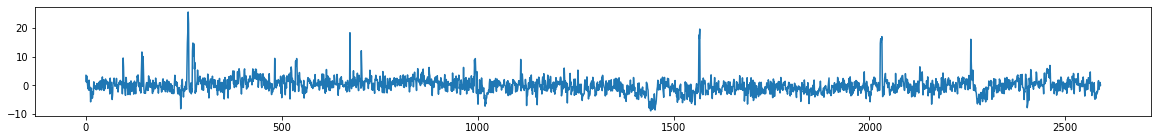

In [13]:
plt.figure(figsize=(20,2))
sbn.lineplot(list(range(len(noise))), noise)

## *Calculo de anomalias*

In [14]:
sigma = np.sqrt(np.var(y_ts_train - y_p))

In [15]:
anomalies_index = np.argwhere(np.abs(noise) - 2.2*sigma > 0)

## *Anomalias sobre la serie con la transformacion box-cox*

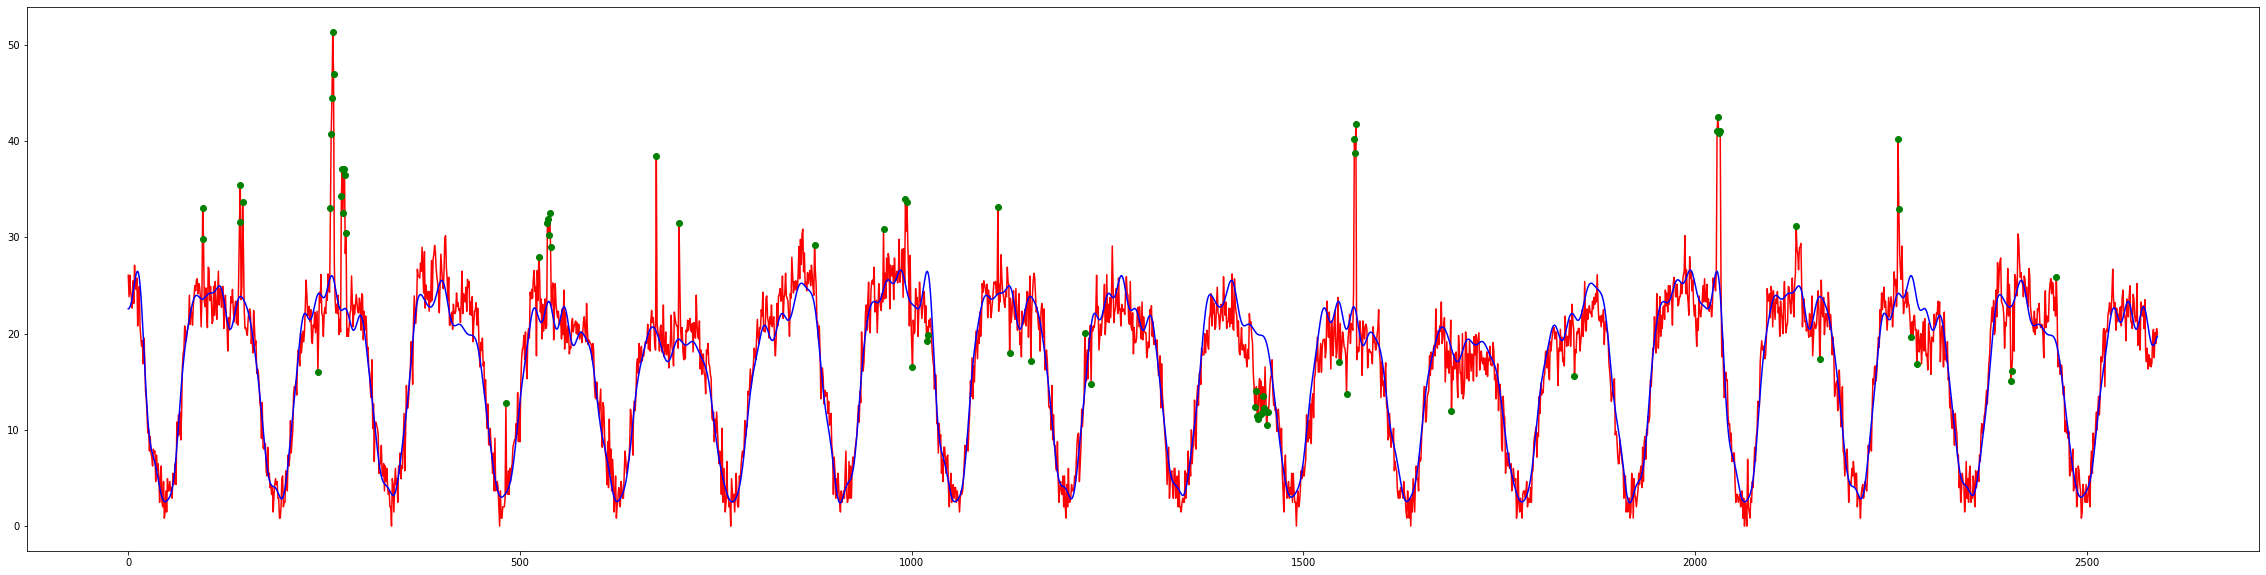

In [16]:
plt.figure(figsize=(40,10))
plt.plot(y_ts_train,"-r")
plt.plot(y_p, "-b")
plt.plot(anomalies_index, y_ts_train[anomalies_index], "og")

## *Anomalias sobre la serie original mostrando los indices de la serie con box-cox*

In [242]:
x_ts, y_ts = get_ts('activities-checkout',df, apply_box_cox=False, lamb=0.5)
#For train everything except the last four days
x_ts_train = x_ts[:-TEST]
y_ts_train = y_ts[:-TEST]

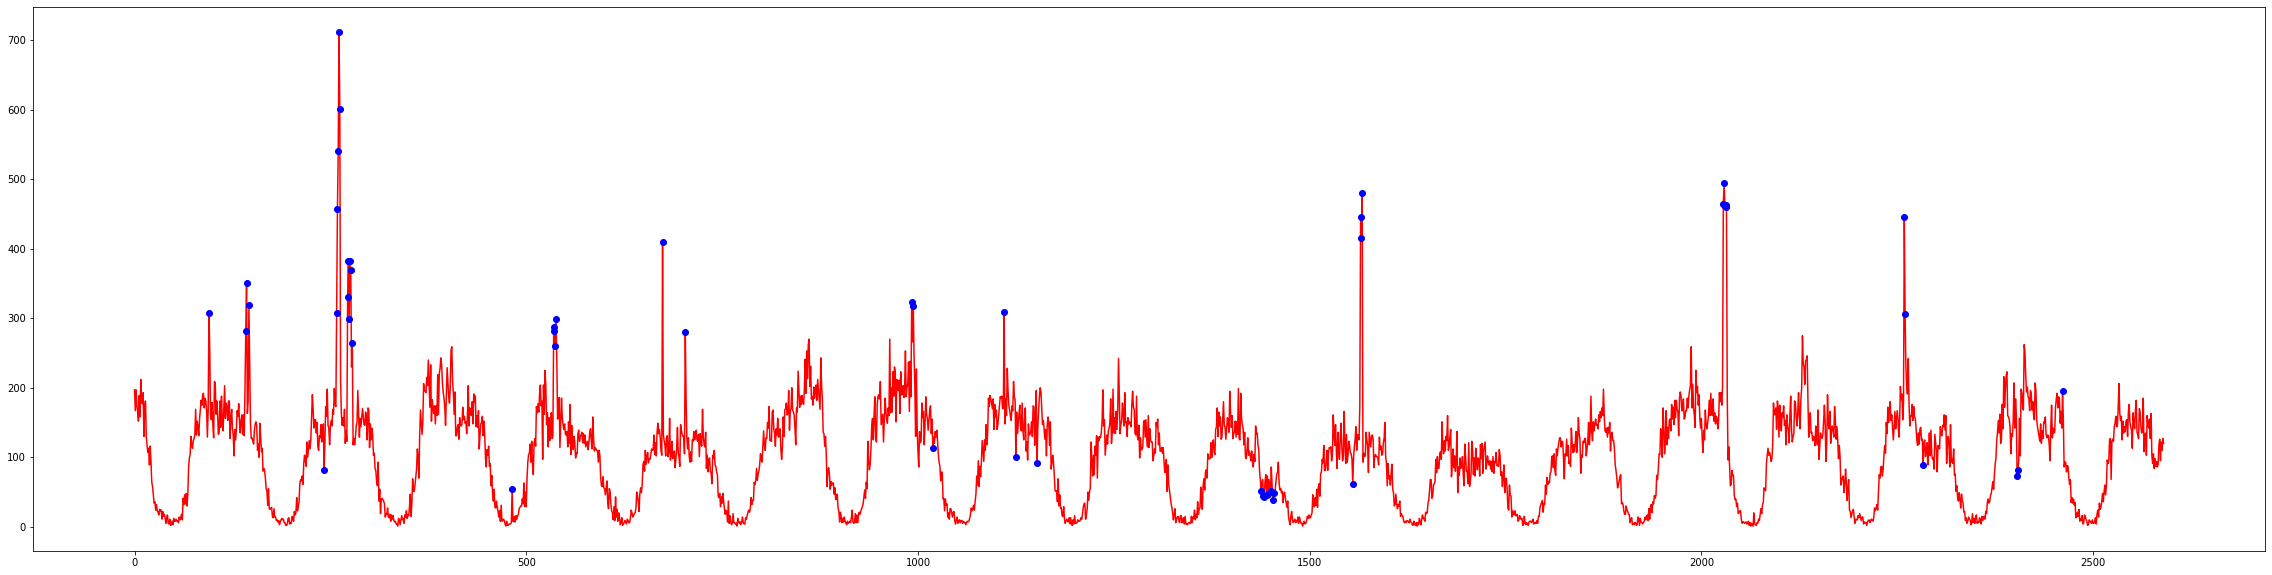

In [245]:
plt.figure(figsize=(40,10))
plt.plot(y_ts_train,"-r")
plt.plot(anomalies_index, y_ts_train[anomalies_index], "ob")